# CUSTOMER CHURN

## Business Understanding


### Import libraries

### Explanation of features

NAMES OF COLUMNS AND DEFINITIONS

* REGION:---------The location of each client
* TENURE:---------Duration in the network
* MONTANT:--------Top-up amount
* FREQUENCE_RECH:-A number of times the customer refilled
* REVENUE:--------Monthly income of each client
* ARPU_SEGMENT:---Income over 90 days/3
* FREQUENCE:------Number of times the client has made an income
* DATA_VOLUME:----Number of connections
* ON_NET:---------Inter expresso call
* ORANGE:---------Call to Orange
* TIGO:-----------Call to Tigo
* ZONE1:----------Call to Zones 1
* ZONE2:----------Call to Zones 2
* MRG:------------A client who is going
* REGULARITY:-----Number of times the client is active for 90 days
* TOP_PACK:-------The most active packs
* FREQ_TOP_PACK:--Number of times the client has activated the top pack packages
* CHURN:----------Variable to predict - Target


### Business Goal

To develop a predictive model that determines the likelihood for a customer to churn(to stop purchasing airtime and data from the client)

### Hypothesis & Analytical Questions

Analytical Questions

1) What is the effect of tenure on churn rate?

2) Which region is churning most?

3) Is there an indication of regularity on churn?

4) What is the effect of refill on churn?

5) Does monthly income affect churn rate?

## Data Understanding

### Import libraries

In [1]:
import pandas as pd
import numpy as np

import pyodbc

import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from scipy.stats import pointbiserialr
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

### Load dataset

In [2]:
# Read the CSV file into a Pandas DataFrame
# Display names of columns

df = pd.read_csv('dataset\Train (2).csv')
df.columns

Index(['user_id', 'REGION', 'TENURE', 'MONTANT', 'FREQUENCE_RECH', 'REVENUE',
       'ARPU_SEGMENT', 'FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO',
       'ZONE1', 'ZONE2', 'MRG', 'REGULARITY', 'TOP_PACK', 'FREQ_TOP_PACK',
       'CHURN'],
      dtype='object')

### EDA

In [3]:
# use .info to get a summary(index, column data types, non-null values) of dataframe. 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1077024 entries, 0 to 1077023
Data columns (total 19 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   user_id         1077024 non-null  object 
 1   REGION          652687 non-null   object 
 2   TENURE          1077024 non-null  object 
 3   MONTANT         699139 non-null   float64
 4   FREQUENCE_RECH  699139 non-null   float64
 5   REVENUE         714669 non-null   float64
 6   ARPU_SEGMENT    714669 non-null   float64
 7   FREQUENCE       714669 non-null   float64
 8   DATA_VOLUME     547261 non-null   float64
 9   ON_NET          683850 non-null   float64
 10  ORANGE          629880 non-null   float64
 11  TIGO            432250 non-null   float64
 12  ZONE1           84898 non-null    float64
 13  ZONE2           68794 non-null    float64
 14  MRG             1077024 non-null  object 
 15  REGULARITY      1077024 non-null  int64  
 16  TOP_PACK        626129 non-null   ob

In [4]:
# check for duplicates values in dataset
# there are no duplicates

df.duplicated().sum()

0

In [5]:
# count the number of missing (null or NaN) values in each column
# compute the percentage of missing values in each column to decide which columns to drop

missing_values = df.isnull().sum()

# Calculate the percentage of missing values for each column
percentage_missing = (missing_values / len(df)) * 100

# Display the percentage of missing values for each column
print(percentage_missing)

user_id            0.000000
REGION            39.399029
TENURE             0.000000
MONTANT           35.086033
FREQUENCE_RECH    35.086033
REVENUE           33.644097
ARPU_SEGMENT      33.644097
FREQUENCE         33.644097
DATA_VOLUME       49.187669
ON_NET            36.505593
ORANGE            41.516624
TIGO              59.866261
ZONE1             92.117353
ZONE2             93.612584
MRG                0.000000
REGULARITY         0.000000
TOP_PACK          41.864898
FREQ_TOP_PACK     41.864898
CHURN              0.000000
dtype: float64


The following columns will be dropped because of redundancy and percentage of missing values.  
* user_id : this column is redundant because its roles is captured by the DataFrame's index
* TIGO: It has a large percentage of missing values (59.8%)
* ZONE1: It has a large percentage of missing values (92.1%)
* ZONE2: it has a large percentage of missing values (93.6%)

In [6]:
#list columns to drop and drop them inplace

columns_to_drop = ['user_id','TIGO','ZONE1','ZONE2']
df.drop(columns=columns_to_drop, inplace=True)
df.head()

,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,DAKAR,K > 24 month,20000.0,47.0,21602.0,7201.0,52.0,8835.0,3391.0,396.0,NO,62,On net 200F=Unlimited _call24H,30.0,0
1,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,3,NaN,NaN,0
2,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,1,NaN,NaN,0
3,SAINT-LOUIS,K > 24 month,7900.0,19.0,7896.0,2632.0,25.0,9385.0,27.0,46.0,NO,61,"Data:490F=1GB,7d",7.0,0
4,DAKAR,K > 24 month,12350.0,21.0,12351.0,4117.0,29.0,9360.0,66.0,102.0,NO,56,All-net 500F=2000F;5d,11.0,0


In [7]:
df['REGION'].value_counts()

REGION
DAKAR          256259
THIES           90171
SAINT-LOUIS     59895
LOUGA           49679
KAOLACK         48498
DIOURBEL        33564
TAMBACOUNDA     27562
KAFFRINE        22067
KOLDA           19464
FATICK          17775
MATAM           14650
ZIGUINCHOR      11036
SEDHIOU          1553
KEDOUGOU          514
Name: count, dtype: int64

In [11]:

# Drop rows with missing values
df_dropped = df.dropna()

# Display the DataFrame after dropping missing values
print("\nDataFrame after dropping missing values:")
print(df_dropped)


DataFrame after dropping missing values:
              REGION         TENURE  MONTANT  FREQUENCE_RECH  REVENUE  \
0              DAKAR   K > 24 month  20000.0            47.0  21602.0   
3        SAINT-LOUIS   K > 24 month   7900.0            19.0   7896.0   
4              DAKAR   K > 24 month  12350.0            21.0  12351.0   
5              DAKAR    E 6-9 month   2000.0             2.0   2000.0   
9              THIES   K > 24 month   6500.0            13.0   6499.0   
...              ...            ...      ...             ...      ...   
1077014        DAKAR  I 18-21 month   5150.0            16.0   5447.0   
1077015        THIES   K > 24 month    700.0             2.0    700.0   
1077016        DAKAR   K > 24 month  14800.0            34.0  16189.0   
1077020  TAMBACOUNDA   K > 24 month   2500.0             5.0   2500.0   
1077023       FATICK   K > 24 month   1500.0             4.0   1499.0   

         ARPU_SEGMENT  FREQUENCE  DATA_VOLUME  ON_NET  ORANGE MRG  REGULARITY  \


In [12]:
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 297482 entries, 0 to 1077023
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   REGION          297482 non-null  object 
 1   TENURE          297482 non-null  object 
 2   MONTANT         297482 non-null  float64
 3   FREQUENCE_RECH  297482 non-null  float64
 4   REVENUE         297482 non-null  float64
 5   ARPU_SEGMENT    297482 non-null  float64
 6   FREQUENCE       297482 non-null  float64
 7   DATA_VOLUME     297482 non-null  float64
 8   ON_NET          297482 non-null  float64
 9   ORANGE          297482 non-null  float64
 10  MRG             297482 non-null  object 
 11  REGULARITY      297482 non-null  int64  
 12  TOP_PACK        297482 non-null  object 
 13  FREQ_TOP_PACK   297482 non-null  float64
 14  CHURN           297482 non-null  int64  
dtypes: float64(9), int64(2), object(4)
memory usage: 36.3+ MB


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MONTANT,699139.0,5529.210895,7104.737952,20.0,1000.0,3000.0,7350.0,470000.0
FREQUENCE_RECH,699139.0,11.523756,13.261938,1.0,2.0,7.0,16.0,131.0
REVENUE,714669.0,5506.050798,7175.625010,1.0,1000.0,3000.0,7360.0,532177.0
ARPU_SEGMENT,714669.0,1835.355961,2391.870902,0.0,333.0,1000.0,2453.0,177392.0
FREQUENCE,714669.0,13.974439,14.687059,1.0,3.0,9.0,20.0,91.0
DATA_VOLUME,547261.0,3368.801722,12898.928039,0.0,0.0,258.0,2905.0,1702309.0
ON_NET,683850.0,277.065798,874.315378,0.0,5.0,27.0,156.0,50809.0
ORANGE,629880.0,95.160804,203.020261,0.0,7.0,29.0,99.0,12040.0
REGULARITY,1077024.0,28.044496,22.288610,1.0,6.0,24.0,51.0,62.0
FREQ_TOP_PACK,626129.0,9.262446,12.242316,1.0,2.0,5.0,12.0,624.0


In [13]:
df_dropped.describe().T

,count,mean,std,min,25%,50%,75%,max
MONTANT,297482.0,7565.081323,7758.928540,50.0,2500.0,5300.0,10000.0,290500.0
FREQUENCE_RECH,297482.0,15.920056,14.945765,1.0,5.0,11.0,22.0,131.0
REVENUE,297482.0,7729.881401,7884.630405,11.0,2500.0,5440.0,10331.0,233413.0
ARPU_SEGMENT,297482.0,2576.629463,2628.208015,4.0,833.0,1813.0,3444.0,77804.0
FREQUENCE,297482.0,19.469793,16.229215,1.0,7.0,15.0,27.0,91.0
DATA_VOLUME,297482.0,4127.607872,9152.492724,0.0,0.0,554.0,4638.0,510333.0
ON_NET,297482.0,383.902922,1036.293178,0.0,10.0,55.0,273.0,50809.0
ORANGE,297482.0,119.323529,233.754242,0.0,12.0,42.0,131.0,6555.0
REGULARITY,297482.0,47.762221,15.129740,1.0,38.0,53.0,61.0,62.0
FREQ_TOP_PACK,297482.0,11.378900,13.548696,1.0,3.0,7.0,15.0,624.0


In [26]:
df_dropped.head(20)

,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,DAKAR,K > 24 month,20000.0,47.0,21602.0,7201.0,52.0,8835.0,3391.0,396.0,NO,62,On net 200F=Unlimited _call24H,30.0,0
3,SAINT-LOUIS,K > 24 month,7900.0,19.0,7896.0,2632.0,25.0,9385.0,27.0,46.0,NO,61,"Data:490F=1GB,7d",7.0,0
4,DAKAR,K > 24 month,12350.0,21.0,12351.0,4117.0,29.0,9360.0,66.0,102.0,NO,56,All-net 500F=2000F;5d,11.0,0
5,DAKAR,E 6-9 month,2000.0,2.0,2000.0,667.0,3.0,4206.0,246.0,709.0,NO,62,"On-net 500=4000,10d",1.0,0
9,THIES,K > 24 month,6500.0,13.0,6499.0,2166.0,14.0,1.0,97.0,81.0,NO,61,All-net 500F=2000F;5d,12.0,0
13,SAINT-LOUIS,K > 24 month,2600.0,13.0,2600.0,867.0,13.0,272.0,2.0,24.0,NO,18,"Data:200F=Unlimited,24H",12.0,0
16,THIES,K > 24 month,2500.0,5.0,2499.0,833.0,7.0,1799.0,195.0,19.0,NO,24,"Data:490F=1GB,7d",3.0,0
17,MATAM,K > 24 month,6400.0,13.0,6251.0,2084.0,21.0,0.0,474.0,118.0,NO,54,On net 200F=Unlimited _call24H,9.0,0
18,DAKAR,K > 24 month,71000.0,14.0,72280.0,24093.0,81.0,4123.0,178.0,1167.0,NO,62,IVR Echat_Daily_50F,79.0,0
20,FATICK,K > 24 month,1450.0,3.0,1450.0,483.0,4.0,2209.0,45.0,2.0,NO,29,"Data:200F=Unlimited,24H",1.0,0


In [15]:
# show distribution of object data types
# Use .describe(include='O') for object dtype columns

object_stats = df.describe(include='O').T

print(object_stats)

            count unique                    top     freq
REGION     652687     14                  DAKAR   256259
TENURE    1077024      8           K > 24 month  1021853
MRG       1077024      1                     NO  1077024
TOP_PACK   626129    126  All-net 500F=2000F;5d   158779


Drop MRG and TOP_PACK columns does not add valuable insights to the analysis
* MRG has only one unique value 
* TOP_PACK has 126 unique values and FREQ_TOP_PACK column will capture enough information for our analysis


In [16]:
#drop MRG and TOP_PACK columns inplace

columns_to_drop = ['MRG','TOP_PACK']
df.drop(columns=columns_to_drop, inplace=True)
df.head()

,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,REGULARITY,FREQ_TOP_PACK,CHURN
0,DAKAR,K > 24 month,20000.0,47.0,21602.0,7201.0,52.0,8835.0,3391.0,396.0,62,30.0,0
1,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,0
2,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,0
3,SAINT-LOUIS,K > 24 month,7900.0,19.0,7896.0,2632.0,25.0,9385.0,27.0,46.0,61,7.0,0
4,DAKAR,K > 24 month,12350.0,21.0,12351.0,4117.0,29.0,9360.0,66.0,102.0,56,11.0,0


### EDA

### Univariate and Bivariate Analysis

In [43]:
# Filter rows where 'CHURN' is equal to 1
churned_data = df[df['CHURN'] == 1]

# Group by 'TENURE' and find the maximum value for each 'TENURE'
max_tenure = churned_data.groupby('TENURE')['CHURN'].sum()
print(max_tenure)

TENURE
D 3-6 month          54
E 6-9 month         162
F 9-12 month       1145
G 12-15 month      2395
H 15-18 month      3524
I 18-21 month      6186
J 21-24 month      1414
K > 24 month     187113
Name: CHURN, dtype: int64


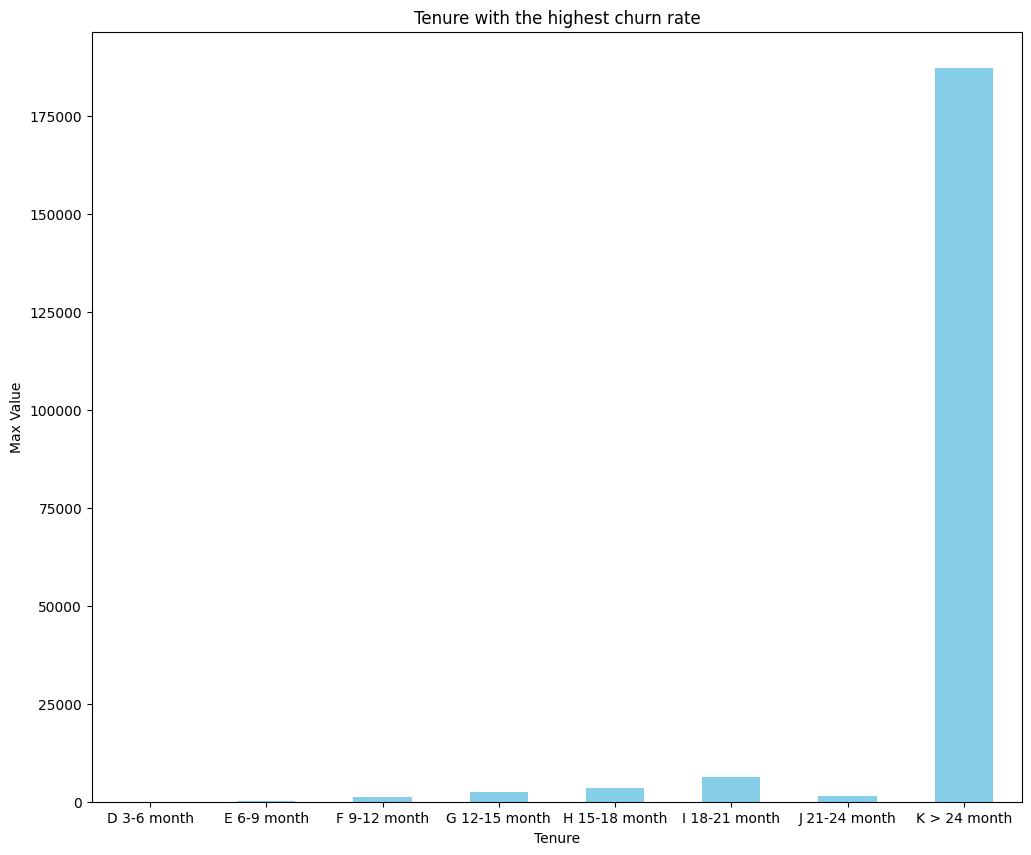

In [49]:
# Filter rows where 'CHURN' is equal to 1
churned_data = df[df['CHURN'] == 1]

# Group by 'TENURE' and find the maximum value for each 'TENURE'
max_tenure = churned_data.groupby('TENURE')['CHURN'].sum()


# Display only 'TENURE' and 'CHURN' columns
#print(max_tenure[['TENURE', 'CHURN']])

# Plot the results using a bar plot
plt.figure(figsize=(12, 10))
max_tenure.plot(kind='bar', color='skyblue')
plt.xlabel('Tenure')
plt.ylabel('Max Value')
plt.title('Tenure with the highest churn rate')
plt.xticks(rotation=0)
plt.show()

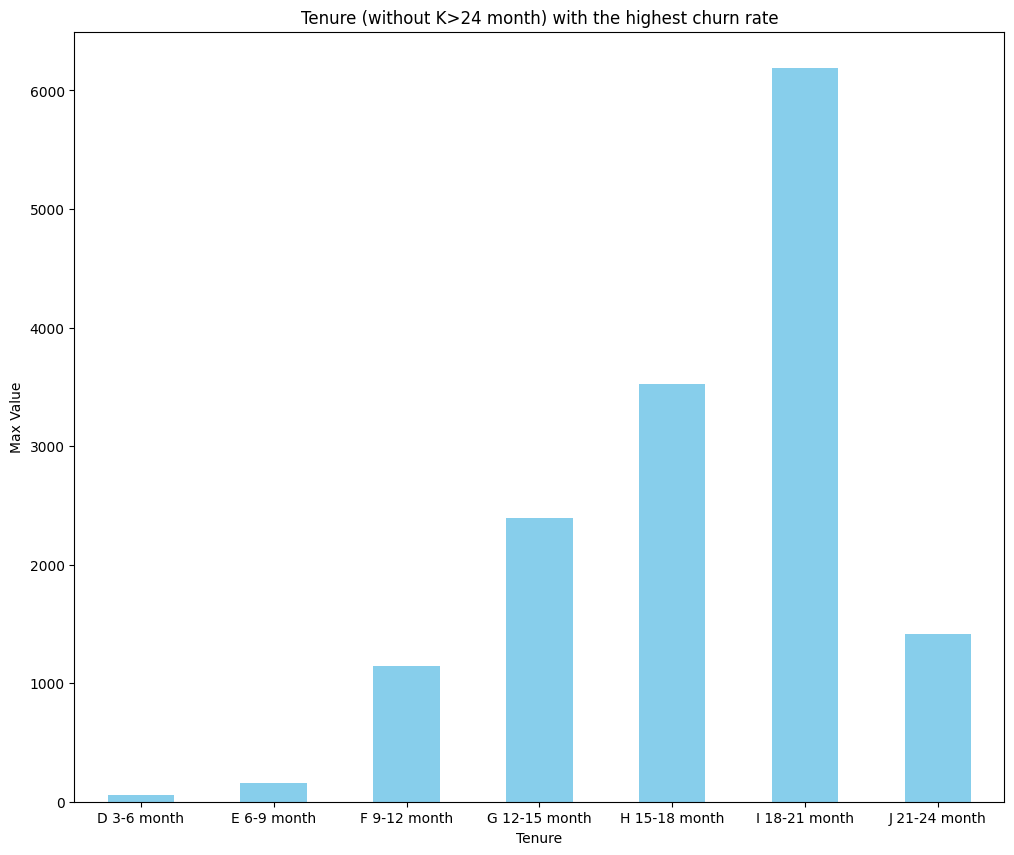

In [51]:
# Filter rows where 'CHURN' is equal to 1
churned_data = df[df['CHURN'] == 1]

# Group by 'TENURE' and find the maximum value for each 'TENURE'
max_tenure = churned_data.groupby('TENURE')['CHURN'].sum()
tenure_without_24month = max_tenure.drop(['K > 24 month'])


# Plot the results using a bar plot
plt.figure(figsize=(12, 10))
tenure_without_24month.plot(kind='bar', color='skyblue')
plt.xlabel('Tenure')
plt.ylabel('Max Value')
plt.title('Tenure (without K>24 month) with the highest churn rate')
plt.xticks(rotation=0)
plt.show()

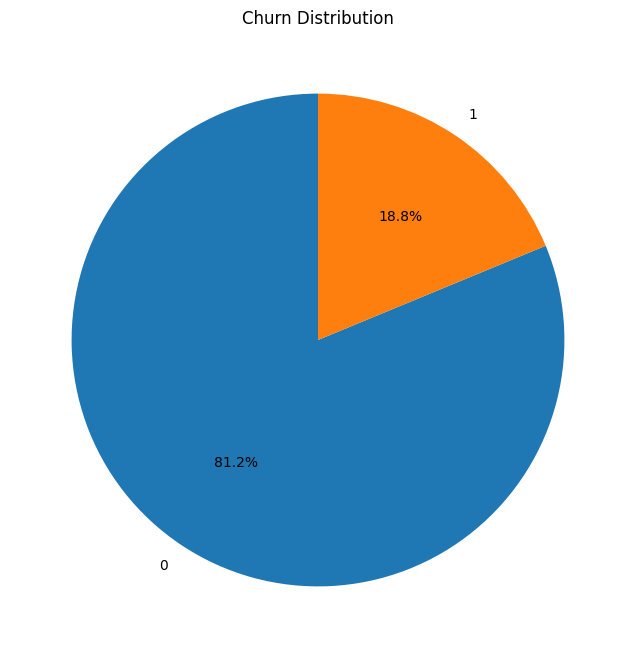

In [31]:
# visualize a pie chart on the distribution of churn 

churn_counts=df['CHURN'].value_counts()

plt.figure(figsize=(8,8))
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Churn Distribution')
plt.show()

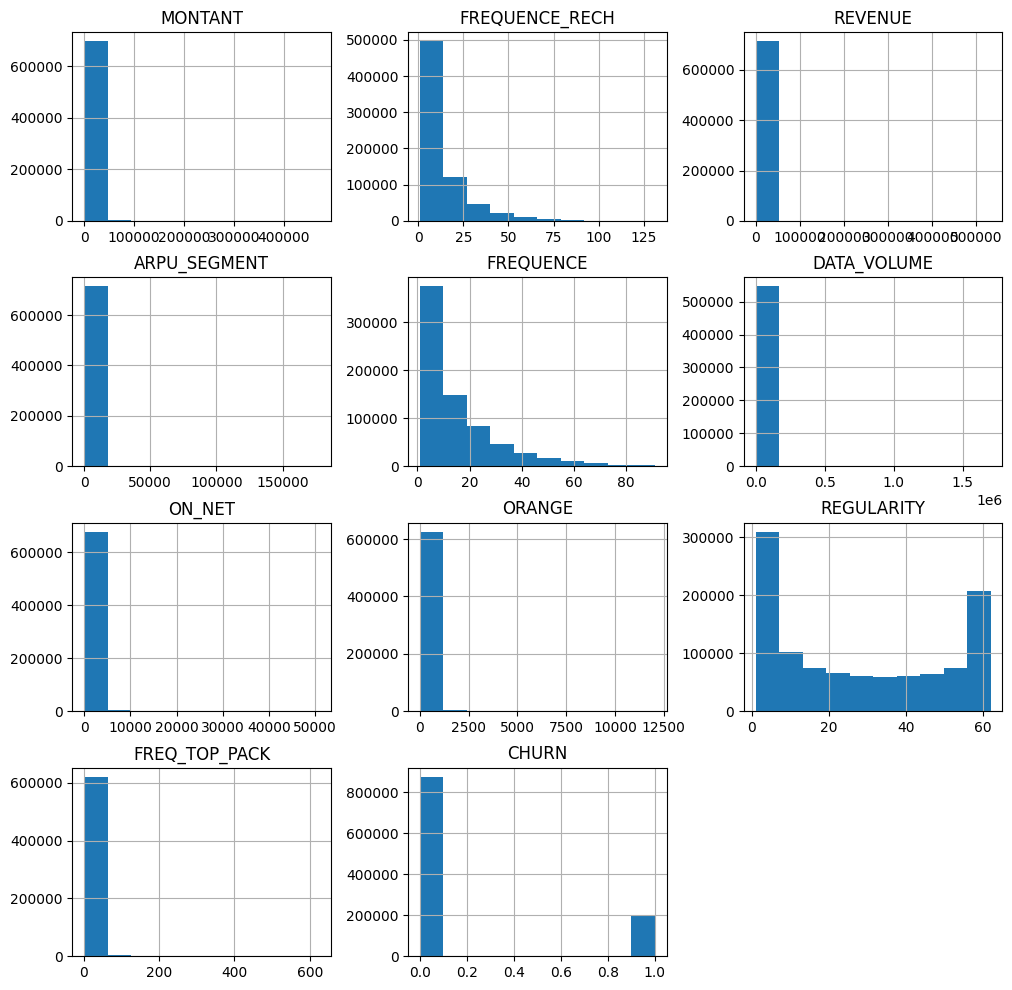

In [27]:
df.hist(figsize=(12,12))
plt.show()

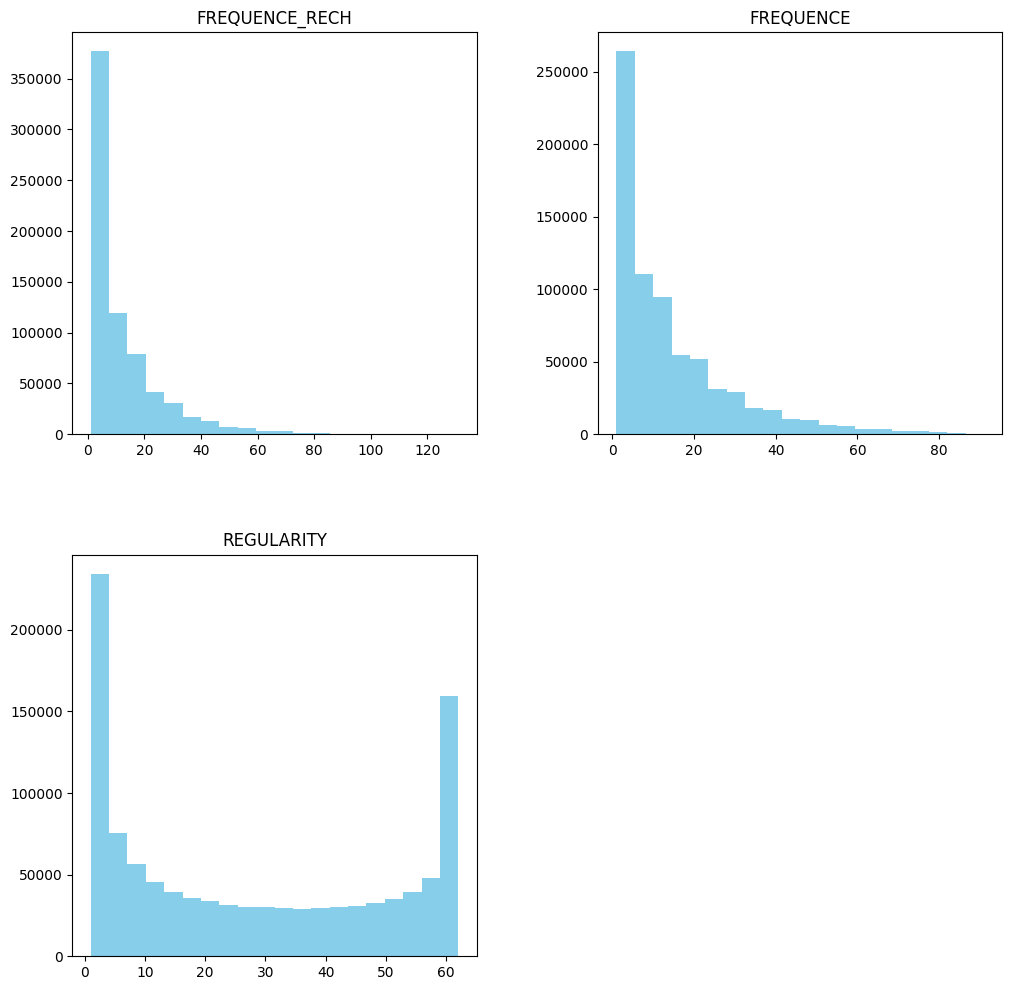

In [28]:

select_columns=['FREQUENCE_RECH','FREQUENCE','REGULARITY']
df[select_columns].hist(figsize=(12,12), grid=False, bins=20, color='skyblue')
plt.show()

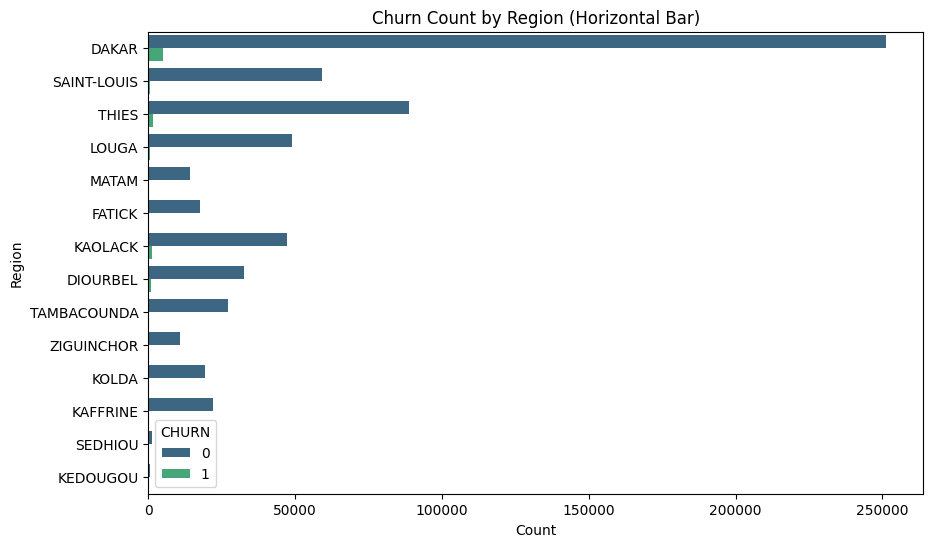

In [53]:
# Plot a horizontal bar plot for 'Region' with hue='Churn'
plt.figure(figsize=(10, 6))
sns.countplot(y='REGION', hue='CHURN', data=df, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Region')
plt.title('Churn Count by Region (Horizontal Bar)')
plt.show()

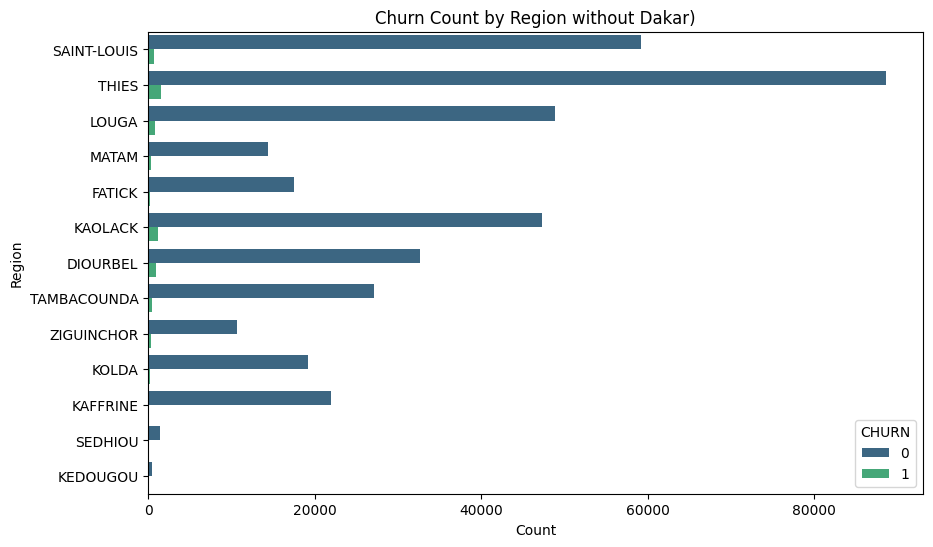

In [65]:

# Plot a horizontal bar plot for 'Region' with hue='Churn'

data_without_dakar=df[df['REGION']!='DAKAR']

plt.figure(figsize=(10, 6))
sns.countplot(y='REGION', hue='CHURN', data=data_without_dakar, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Region')
plt.title('Churn Count by Region without Dakar)')
plt.show()

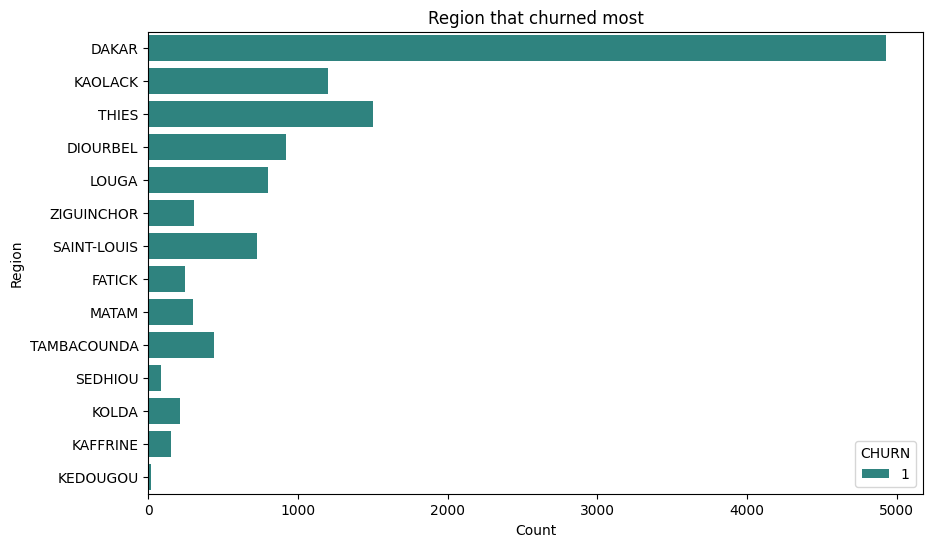

In [63]:
# Plot a horizontal bar plot for 'Region' with hue='Churn'
plt.figure(figsize=(10, 6))
sns.countplot(y='REGION', hue='CHURN', data=churned_data, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Region')
plt.title('Region that churned most')
plt.show()

## Data Preparation

## Modelling 